#Importing the Libraries and Files

In [ ]:
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model, pad_sequences
from tensorflow.keras import layers
from google.colab import files, drive
from time import time
import pandas as pd
import re
import gc
import random
import numpy as np
import tensorflow as tf

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
if "kaggle.json" not in os.listdir():
  files.upload()
  !pip install kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d adityajn105/flickr8k
  !unzip -q flickr8k.zip

Saving kaggle.json to kaggle.json
100% 1.04G/1.04G [00:47<00:00, 24.5MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.2MB/s]


In [ ]:
vgg = VGG16()
feature_extractor = Model(inputs=vgg.inputs,
                          outputs=vgg.layers[-2].output)

553467096/553467096 [==============================] - 25s 0us/step


In [ ]:
features = {}
feature_fileloc = "features-extracted.pkl"
start_time = time()
if feature_fileloc not in os.listdir():
  img_path = "/content/Images/"
  tot_files = len(os.listdir(img_path))
  for img_no, img_name in enumerate(os.listdir(img_path)):
    img = image.load_img(img_path + img_name,
                        target_size=(224, 224))
    img = image.img_to_array(img)
    img_arr = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    prep_img = preprocess_input(img_arr)
    feat_extracted = feature_extractor.predict(prep_img,
                                  verbose=0)
    features[img_name] = feat_extracted
    if (img_no + 1) % 100 == 0:
      passed = time() - start_time
      eta = passed * (tot_files/img_no - 1)
      print(f"{img_no+1} of {tot_files} Time Passed: {passed} ETA: {eta}")

  with open(feature_fileloc, "wb") as feature_file:
    pickle.dump(features, feature_file)
  del features
  gc.collect()
else:
  with open(feature_fileloc, "rb") as feature_file:
    features = pickle.load(feature_file)

In [ ]:
df = pd.read_csv("/content/captions.txt")

In [ ]:
def clean(text):
  text = text.lower()
  text = re.sub(r"[^a-z ]", "", text)
  text = re.sub(r"\s+", " ", text)
  text = "<startseq> " + text + " <endseq>"
  return text

df["caption"] = df.caption.map(clean)

In [ ]:
captions = {}
for i, row in df.iterrows():
  if row.image not in captions:
    captions[row.image] = [row.caption]
  else:
    captions[row.image].append(row.caption)

In [ ]:
corpus = []
for v in captions.values():
  corpus += v

In [ ]:
corpus

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way  <endseq>',
 '<startseq> a girl going into a wooden building  <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse  <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse  <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin  <endseq>',
 '<startseq> a black dog and a spotted dog are fighting <endseq>',
 '<startseq> a black dog and a tricolored dog playing with each other on the road  <endseq>',
 '<startseq> a black dog and a white dog with brown spots are staring at each other in the street  <endseq>',
 '<startseq> two dogs of different breeds looking at each other on the road  <endseq>',
 '<startseq> two dogs on pavement moving toward each other  <endseq>',
 '<startseq> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <endseq>',
 '<startseq> a little girl is sitting in front of a large painted ra

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpus)
voc_size = len(tokenizer.word_index) + 1
voc_size

8781

#Splitting the data into train, validation and test sets

In [ ]:
img_files = set(os.listdir("/content/Images"))
tot_files = len(img_files)

In [ ]:
def split_data(data_size):
  img_no = 0
  data = set()
  while img_no < data_size:
    new_img = random.choice(list(img_files))
    if new_img not in data:
      data.add(new_img)
      img_no += 1
  return data

In [ ]:
train_size = int(0.9 * tot_files)

train_data = split_data(train_size)
val_data = img_files - train_data

train_data = list(train_data)
val_data = list(val_data)

#Creating data generator to load the data in batches

In [ ]:
maxlen = max(len(caption.split()) for caption in corpus)

In [ ]:
def gen_batches(data_keys, mapping,
                features, tokenizer,
                max_length, vocab_size,
                batch_size):
  x_img, x_text, y = [], [], []
  n = 0
  while True:
    for key in data_keys:
      n += 1
      img_captions = mapping[key]
      for caption in img_captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(len(seq)):
          context, future = seq[:i], seq[i]

          context = pad_sequences([context],
                                  maxlen=maxlen)[0]
          future = to_categorical([future],
                                  num_classes=voc_size)[0]

          x_img.append(features[key][0])
          x_text.append(context)
          y.append(future)

      if n==batch_size or key==len(data_keys):
        x_img, x_text, y = np.array(x_img), np.array(x_text), np.array(y)
        yield [x_img, x_text], y
        x_img, x_text, y = [], [], []
        n = 0

#Creating the model

## encoder

### image encoder

In [ ]:
input_img = layers.Input(shape=(4096,))
img_encoder = layers.Dropout(0.4)(input_img)
img_encoder = layers.Dense(256, activation="relu")(img_encoder)

### text encoder

In [ ]:
input_seq = layers.Input(shape=(maxlen, ))
seq_encoder = layers.Embedding(voc_size, 256,
                               mask_zero=True)(input_seq)
seq_encoder = layers.Dropout(0.5)(seq_encoder)
seq_encoder = layers.LSTM(256)(seq_encoder)

## decoder

In [ ]:
decoder = layers.add([img_encoder, seq_encoder])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(voc_size,
                      activation="softmax",
                      name="next_word_layer")(decoder)

## Combining and Compiling

In [ ]:
model = Model(inputs=[input_img, input_seq],
              outputs=output,
              name="ImageCaptioner")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
model.summary()

Model: "ImageCaptioner"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 37, 256)      2247936     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                     

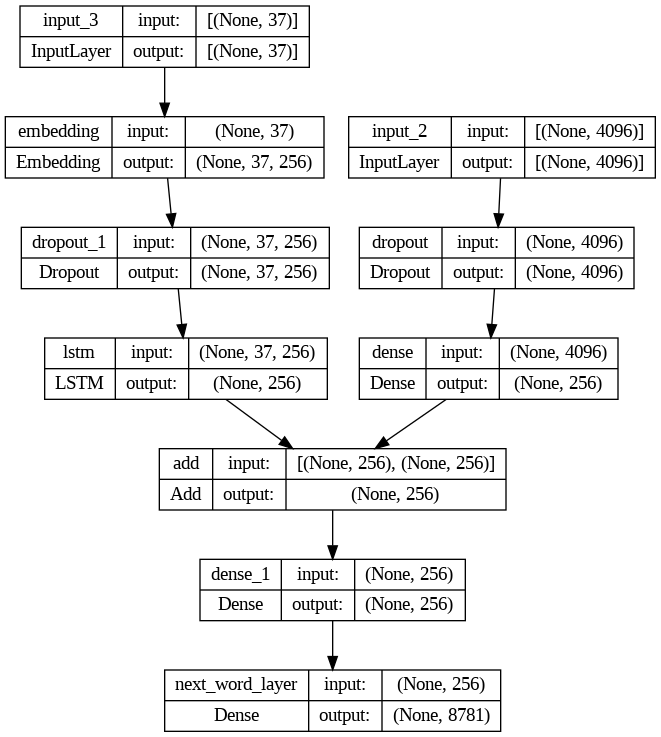

In [ ]:
plot_model(model,
           show_shapes=True)

##Training the model

In [ ]:
epochs=15
batch_size = 32
epoch_steps = len(train_data)//batch_size

In [ ]:
train_gen = gen_batches(train_data, captions, features,
                        tokenizer, maxlen, voc_size, batch_size)
val_gen = train_gen = gen_batches(val_data, captions, features,
                        tokenizer, maxlen, voc_size, batch_size)

In [ ]:
for i in range(epochs):
  model.fit(train_gen,
            epochs=1,
            steps_per_epoch=epoch_steps)

 58/227 [======>.......................] - ETA: 53s - loss: 1.9084

In [ ]:
model.save("image_captioner.h5")

In [ ]:
model = load_model("/content/drive/MyDrive/image_captioner.h5")

In [ ]:
with open("tokenizer.pkl", "wb") as tokenizer_file:
  pickle.dump(tokenizer, tokenizer_file)

In [ ]:
with open("tokenizer.pkl", "rb") as tok_file:
  tokenizer = pickle.load(tok_file)

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

def gen_caption(model, img_path, tokenizer, max_length):
  text = "<startseq>"
  img = image.load_img(img_path,
                        target_size=(224, 224))
  img = image.img_to_array(img)
  img_arr = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  prep_img = preprocess_input(img_arr)
  feat_extracted = feature_extractor.predict(prep_img,
                                 verbose=0)

  for i in range(max_length):
    seq = tokenizer.texts_to_sequences([text])[0]
    seq = pad_sequences([seq], max_length)[0]
    y_pred = np.argmax(model.predict([feat_extracted, np.array([seq])],
                                     verbose=0))
    word = tokenizer.sequences_to_texts(np.array([[y_pred]]))[0]
    if not word or word == "endseq":
      break
    text += " " + word
  plt.imshow(Image.open(img_path))
  plt.axis("off")
  plt.title(" ".join(text.split()[1:]), fontsize=28)
  # return " ".join(text.split()[1:])

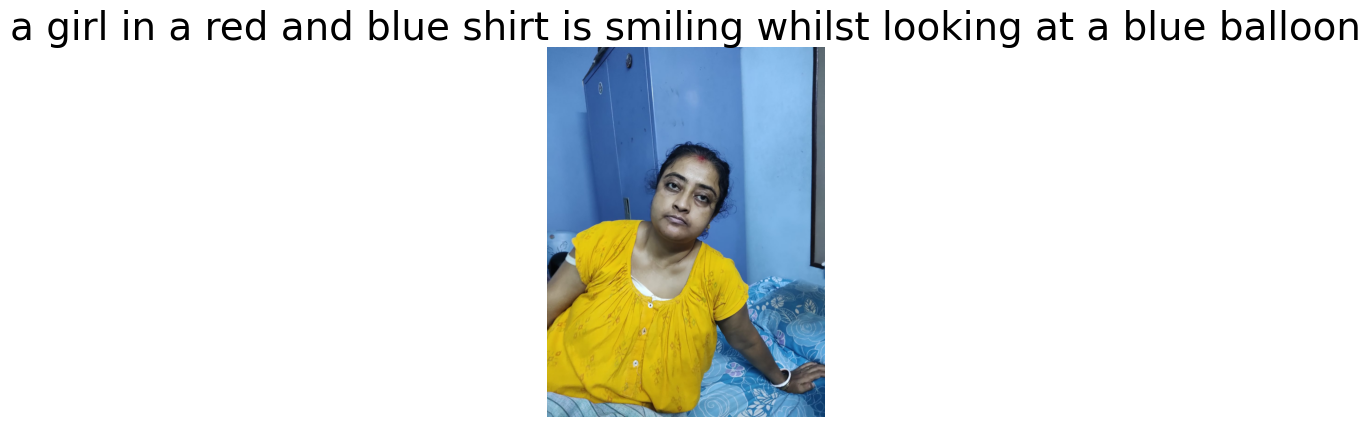

In [ ]:
gen_caption(model, "//content/WhatsApp Image 2023-08-14 at 12.34.13 AM.jpeg", tokenizer, 37)